# Probabilistic forecasting 

> In this example, we'll implement prediction intervals 

::: {.callout-warning collapse="true"}

## Prerequesites

This tutorial assumes basic familiarity with MLForecast. For a minimal example visit the [Quick Start](https://nixtla.github.io/mlforecast/docs/quick_start_local.html) 
:::

## Introduction 




When we generate a forecast, we usually produce a single value known as the point forecast. This value, however, doesn't tell us anything about the uncertainty associated with the forecast. To have a measure of this uncertainty, we need **prediction intervals**. 

A prediction interval is a range of values that the forecast can take with a given probability. Hence, a 95% prediction interval should contain a range of values that include the actual future value with probability 95%. Probabilistic forecasting aims to generate the full forecast distribution. Point forecasting, on the other hand, usually returns the mean or the median or said distribution. However, in real-world scenarios, it is better to forecast not only the most probable future outcome, but many alternative outcomes as well. 

With [MLForecast](https://nixtla.github.io/mlforecast/) you can train `sklearn` models to generate point forecasts. It also takes the advantages of `ConformalPrediction` to generate the same point forecasts and adds them prediction intervals. By the end of this tutorial, you'll have a good understanding of how to add probabilistic intervals to `sklearn` models for time series forecasting. Furthermore, you'll also learn how to generate plots with the historical data, the point forecasts, and the prediction intervals. 

::: {.callout-important}
## Important 
Although the terms are often confused, prediction intervals are not the same as [confidence intervals](https://robjhyndman.com/hyndsight/intervals/). 
:::

::: {.callout-warning}
## Warning 
In practice, most prediction intervals are too narrow since models do not account for all sources of uncertainty. A discussion about this can be found [here](https://robjhyndman.com/hyndsight/narrow-pi/). 
:::


**Outline:**

1. Install libraries 
2. Load and explore the data
3. Train models 
4. Plot prediction intervals 

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/prediction_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](https://nixtla.github.io/statsforecast/examples/installation.html) 

Install the necessary packages using `pip install mlforecast`

In [ ]:
%%capture
pip install mlforecast statsforecast

## Load and explore the data

For this example, we'll use the hourly dataset from the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). We first need to download the data from a URL and then load it as a `pandas` dataframe. Notice that we'll load the train and the test data separately. We'll also rename the `y` column of the test data as `y_test`.   

In [ ]:
import pandas as pd 

train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In [ ]:
train.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [ ]:
test.head()

,unique_id,ds,y_test
0,H1,701,619.0
1,H1,702,565.0
2,H1,703,532.0
3,H1,704,495.0
4,H1,705,481.0


Since the goal of this notebook is to generate prediction intervals, we'll only use the first 8 series of the dataset to reduce the total computational time. 

In [ ]:
n_series = 8 
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

We can plot these series using the `statsforecast.plot` method from the [StatsForecast](https://nixtla.github.io/statsforecast/core.html#statsforecast) class. This method has multiple parameters, and the required ones to generate the plots in this notebook are explained below. 

- `df`: A `pandas` dataframe with columns [`unique_id`, `ds`, `y`]. 
- `forecasts_df`: A `pandas` dataframe with columns [`unique_id`, `ds`] and models. 
- `plot_random`: bool = `True`. Plots the time series randomly. 
- `models`: List[str]. A list with the models we want to plot. 
- `level`: List[float]. A list with the prediction intervals we want to plot. 
- `engine`: str = `plotly`. It can also be `matplotlib`. `plotly` generates interactive plots, while `matplotlib` generates static plots. 

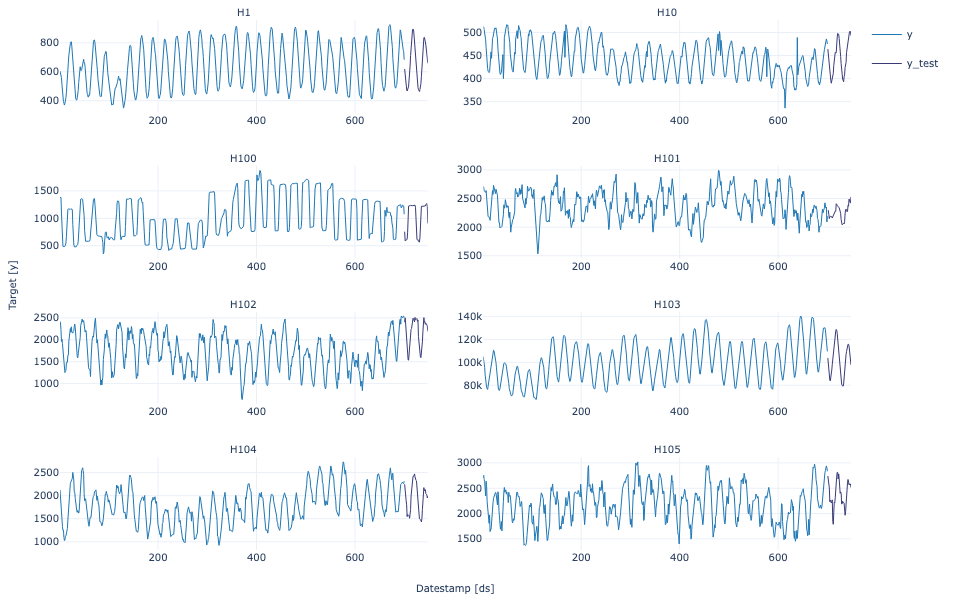

In [ ]:
from statsforecast import StatsForecast as sf

sf.plot(train, test, plot_random=False)

## Train models

MLForecast can train multiple models that follow the `sklearn` syntax (`fit` and `predict`) on different time series efficiently.

For this example, we'll use the following `sklearn` baseline models: 

- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) 
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) 
- [Multilayer Perceptron (NeuralNetwork)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

To use these models, we first need to import them from `sklearn` and then we need to instantiate them.

In [ ]:
from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Create a list of models and instantiation parameters 
models = [
    KNeighborsRegressor(),
    Lasso(),
    LinearRegression(),
    MLPRegressor(),
    Ridge(),
]

To instantiate a new StatsForecast object, we need the following parameters: 

- `models`: The list of models defined in the previous step.  
- `differences`: Differences to take of the target before computing the features. These are restored at the forecasting step. Useful to model trend.
- `lags`: Lags of the target to use as features.

In [ ]:
mlf = MLForecast(
    models=[Ridge(), Lasso(), LinearRegression(), KNeighborsRegressor(), MLPRegressor()],
    differences=[1],
    lags=[24 * (i+1) for i in range(7)],
)

Now we're ready to generate the point forecasts and the prediction intervals. To do this, we'll use the `fit` method, which takes the following arguments: 

- `data`: Series data in long format.
- `id_col`: Column that identifies each series. In our case, `unique_id`.
- `time_col`: Column that identifies each timestep, its values can be timestamps or integers. In our case, `ds`.
- `target_col`: Column that contains the target. In our case, `y`.
- `prediction_intervals`: A `PredicitonIntervals` class. The class takes two parameters: `n_windows` and `window_size`. `n_windows` represents the number of cross-validation windows used to calibrate the intervals and `window_size` is the forecast horizon. The strategy will adjust the intervals for each horizon step, resulting in different widths for each step.

In [ ]:
mlf.fit(
    train, 
    id_col='unique_id', 
    time_col='ds', 
    target_col='y', 
    prediction_intervals=PredictionIntervals(n_windows=10, window_size=48),
);

After fitting the models, we will call the `predict` method to generate forecasts with prediction intervals. The method takes the following arguments:

- `horizon`: An integer that represent the forecasting horizon. In this case, we'll forecast the next 48 hours. 
- `level`: A list of floats with the confidence levels of the prediction intervals. For example, `level=[95]` means that the range of values should include the actual future value with probability 95%. 

In [ ]:
levels = [50, 80, 95]
forecasts = mlf.predict(48, level=levels)
forecasts.head()

,unique_id,ds,Ridge,Lasso,LinearRegression,KNeighborsRegressor,MLPRegressor,Ridge-lo-95,Ridge-lo-80,Ridge-lo-50,...,KNeighborsRegressor-lo-50,KNeighborsRegressor-hi-50,KNeighborsRegressor-hi-80,KNeighborsRegressor-hi-95,MLPRegressor-lo-95,MLPRegressor-lo-80,MLPRegressor-lo-50,MLPRegressor-hi-50,MLPRegressor-hi-80,MLPRegressor-hi-95
0,H1,701,612.418170,612.418079,612.418170,615.2,609.489089,590.472874,593.899316,603.393512,...,609.1,621.3,627.40,631.42,578.566774,586.496072,594.607721,624.370457,632.482105,640.411404
1,H1,702,552.309298,552.308073,552.309298,551.6,541.585887,498.254021,517.334370,530.981769,...,535.7,567.5,569.92,598.55,483.445874,490.189207,504.449841,578.721932,592.982566,599.725900
2,H1,703,494.943384,494.943367,494.943384,509.6,481.629888,448.144481,461.851902,473.407498,...,492.6,526.6,531.04,544.76,408.151370,422.274367,433.480988,529.778788,540.985409,555.108406
3,H1,704,462.815779,462.815363,462.815779,474.6,449.099398,409.837922,421.200799,434.528127,...,451.8,497.4,510.32,526.20,361.757868,378.781102,393.354791,504.844004,519.417693,536.440927
4,H1,705,440.141034,440.140586,440.141034,451.6,426.699358,377.727344,391.544539,412.179300,...,425.6,477.6,489.12,504.59,328.206120,343.741950,364.280929,489.117787,509.656766,525.192597


In [ ]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

## Plot prediction intervals

To plot the point and the prediction intervals, we'll use the `statsforecast.plot` method again. Notice that now we also need to specify the model and the levels that we want to plot. 

### KNeighborsRegressor

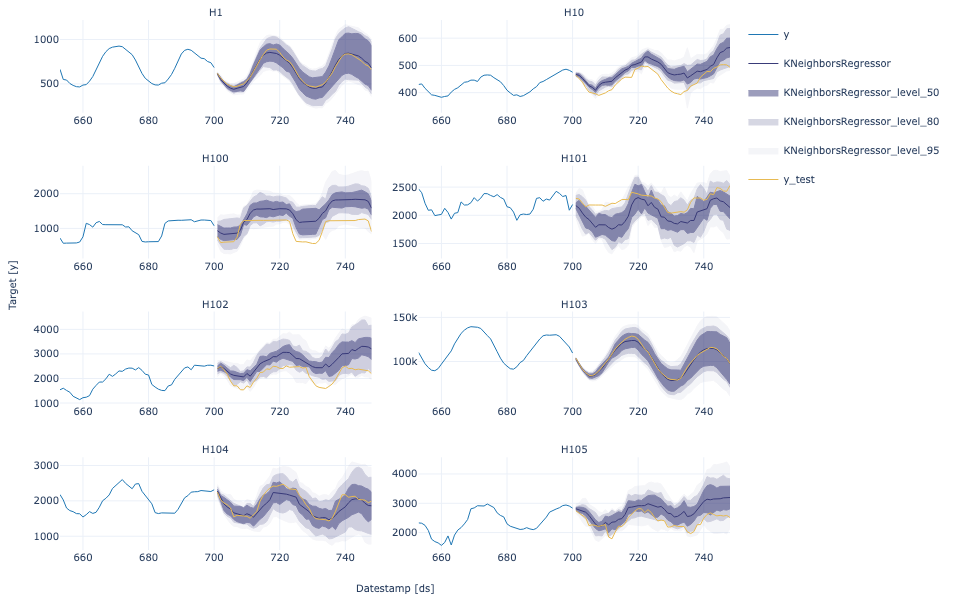

In [ ]:
sf.plot(train, test, plot_random=False, models=['KNeighborsRegressor', 'y_test'], level=levels, max_insample_length=48)

### Lasso

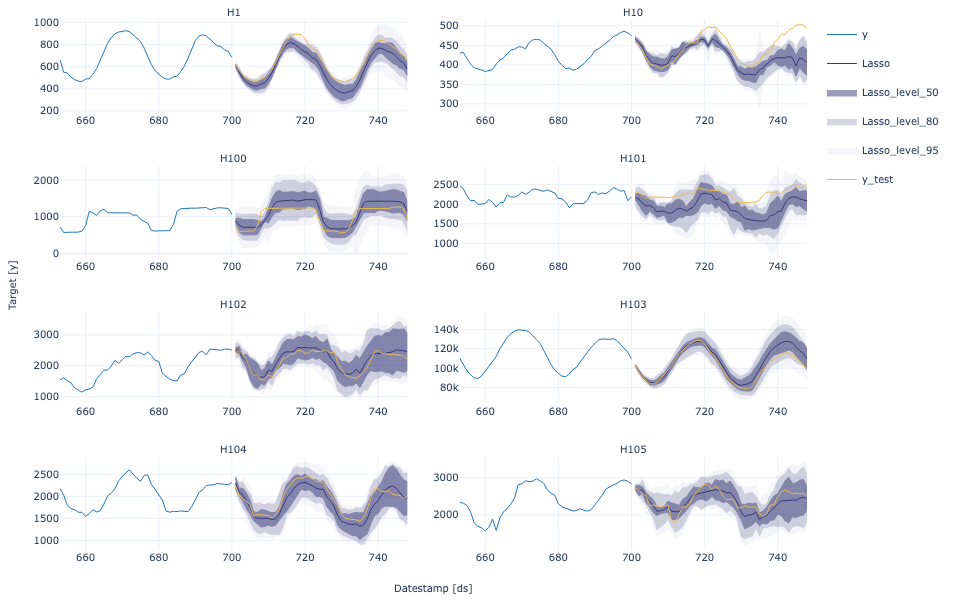

In [ ]:
sf.plot(train, test, plot_random = False, models=['Lasso', 'y_test'], level=levels, max_insample_length=48)

### LineaRegression

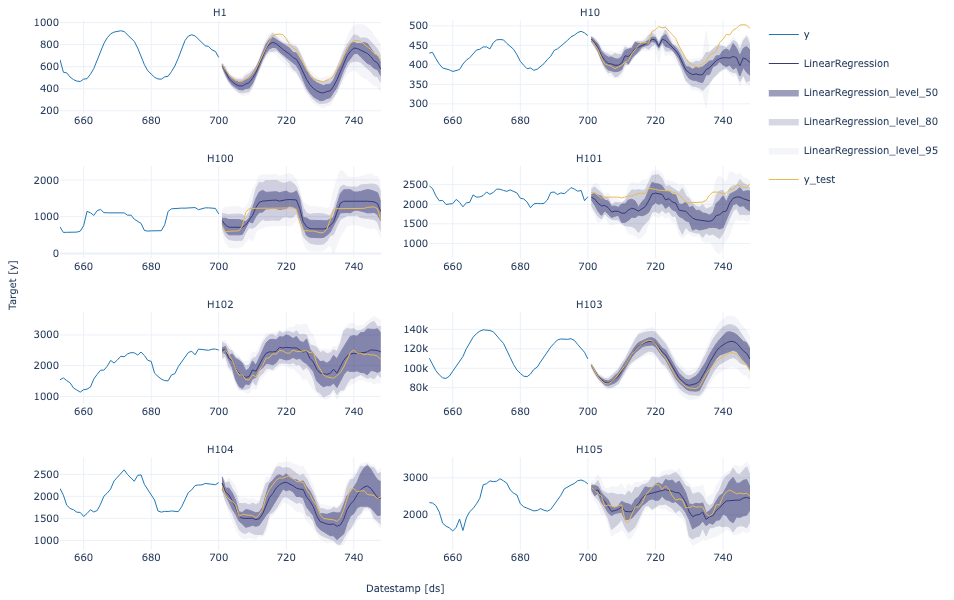

In [ ]:
sf.plot(train, test, plot_random = False, models=['LinearRegression', 'y_test'], level=levels, max_insample_length=48)

### MLPRegressor

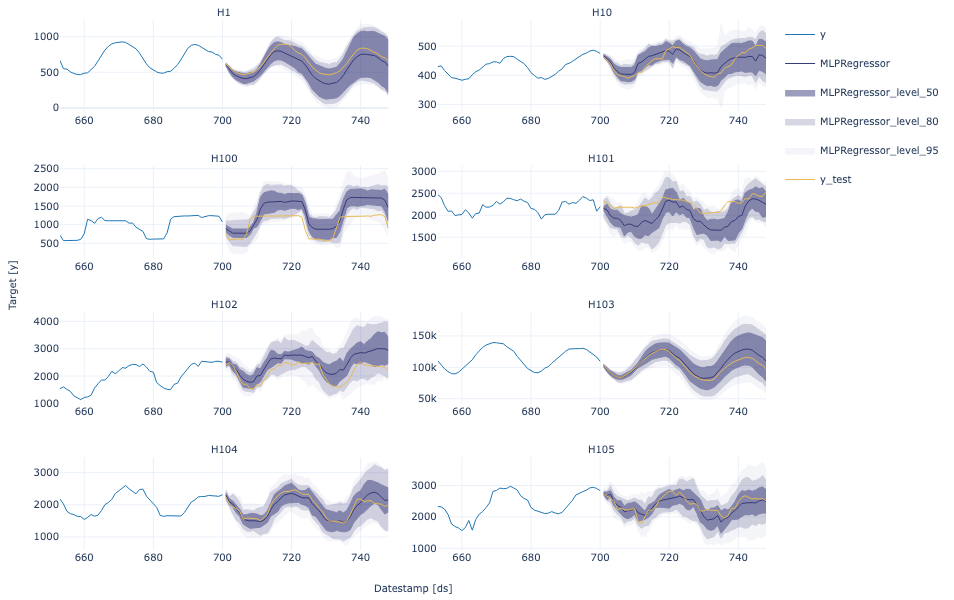

In [ ]:
sf.plot(train, test, plot_random = False, models=['MLPRegressor', 'y_test'], level=levels, max_insample_length=48)

### Ridge

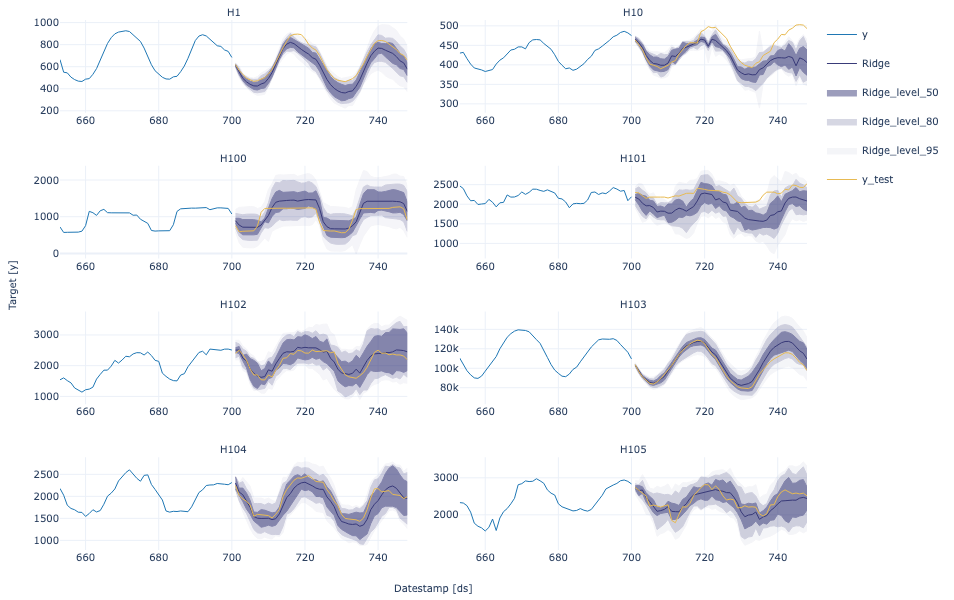

In [ ]:
sf.plot(train, test, plot_random = False, models=['Ridge', 'y_test'], level=levels, max_insample_length=48)

From these plots, we can conclude that the uncertainty around each forecast varies according to the model that is being used. For the same time series, one model can predict a wider range of possible future values than others. 

## References 

- [Kamile Stankeviciute, Ahmed M. Alaa and Mihaela van der Schaar (2021). "Conformal Time-Series Forecasting"](https://proceedings.neurips.cc/paper/2021/file/312f1ba2a72318edaaa995a67835fad5-Paper.pdf)
- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, The Statistical Forecasting Perspective"](https://otexts.com/fpp3/perspective.html).
